In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from scipy.linalg import pascal
from scipy.stats import norm
import warnings
import scipy
warnings.filterwarnings("ignore")

$$\frac{\partial u}{\partial \tau} = \frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial u}{\partial x} \left(1 + \frac{2r}{\sigma^{2}}\right)$$
$$ h = {X \over M} $$
$$ tau = {\widetilde \Tau \over N} $$


$$ u_{m}^{n + 1}  = u_{m}^{n} + {\tau \over h^{2}}  (u_{m - 1}^{n} - 2u_{m}^{n} + u_{m + 1}^{n}) + {\tau \over h}(1 + D)(u_{m - 1}^{n} + u_{m}^{n})$$

In [2]:
T, N = 1, 7 * 10 ** 2
S_1, S_2, K, M = 100, 300, 200, 10 ** 2
r, sigma= 0.1, 0.05
T_wave = (sigma ** 2) * T / 2
D = (2 * r) / (sigma ** 2)
X_1 = np.log(S_1 / K)
X_2 = np.log(S_2 / K)
X_arr = np.linspace(X_1, X_2, M)
tau = T_wave / N
h = abs(X_1 - X_2) / M
print(tau / ((h ** 2) / 2))
U_shape = (N, M)
print('U_shape:', N * M)
U = np.zeros(U_shape)

0.029590551774650833
U_shape: 70000


In [3]:
# инициализация, граничные условия
D = (2 * r) / (sigma ** 2)

for m in range(len(X_arr)):
    if 1 - np.exp(-X_arr[m]) > 0:
        U[0][m] = 1 - np.exp(-X_arr[m])
    else:
        U[0][m] = 0

for n in range(N):
    U[n, -1] = 1 - np.exp(-D * tau * n - X_arr[-1])

In [4]:
def find_u(u_left, u_mid, u_right, tau, h, D):
    # нахождение значения в узле
    ans = u_mid + (tau / (h ** 2)) * (u_left - 2 * u_mid + u_right) + ((tau / h) * (1 + D)) * (u_right - u_mid)
    if ans > 0:
        return ans
    return 0

In [5]:
# поиск значений на сетке
for n in tqdm(range(N - 1)):
    for m in range(1, M - 1):
        U[n + 1, m] = find_u(U[n, m - 1], U[n, m], U[n, m + 1], tau, h, D)
V = U * np.linspace(S_1, S_2, M)
V_numerical = pd.DataFrame(V)
ans_numerical = V_numerical.sum(axis=0) / V_numerical.shape[0]
ans_numerical = ans_numerical

100%|██████████| 699/699 [00:00<00:00, 4590.40it/s]


In [6]:
def d_plus(s, sigma, T, t, r, strike): 
    return ((math.log(s / strike)) + (T - t) * (r + (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [7]:
def d_minus(s, sigma, T, t, r, strike):
    return ((math.log(s / strike)) + (T - t) * (r - (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [8]:
def price_call_option(s, sigma, T, t, r, strike):
    I_plus = norm.cdf(d_plus(s, sigma, T, t, r, strike))
    I_minus = norm.cdf(d_minus(s, sigma, T, t, r, strike))
    ans = s * I_plus - strike * math.exp(-1 * r * (T - t)) * I_minus
    return ans

In [9]:
S_arr = K * np.exp(X_arr)
t_arr = T - (2 / (sigma ** 2)) * np.linspace(0, T_wave, N)

In [10]:
exact = np.zeros((U_shape))
for i in tqdm(range(len(t_arr))):
    for j in range(len(S_arr)):
        exact[i][j] = price_call_option(S_arr[j], sigma, T, t_arr[i], r, K)


100%|██████████| 700/700 [00:17<00:00, 41.14it/s]


In [11]:
V_exact = pd.DataFrame(exact)
ans_exact = V_exact.sum(axis=0) / V_exact.shape[0]
ans_exact

0     5.635939e-35
1     8.222538e-34
2     1.143349e-32
3     1.515313e-31
4     1.914234e-30
          ...     
95    9.664932e+01
96    9.985164e+01
97    1.030897e+02
98    1.063639e+02
99    1.096746e+02
Length: 100, dtype: float64

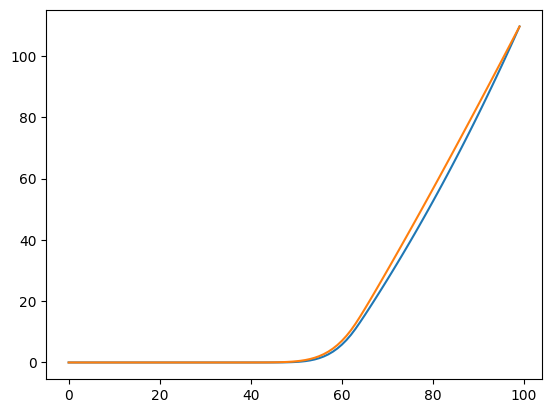

In [12]:
plt.plot(ans_exact)
plt.plot(ans_numerical)